# Parcel delineation using Sentinel-2

<img src="https://avatars.githubusercontent.com/u/74911464?s=200&v=4"
     alt="OpenEO Platform logo"
     style="float: left; margin-right: 6em;" />

Authors:

* Kristof van Tricht (VITO)
* Jeroen Dries (VITO)

Tuning:

* Kasper Bonte (VITO)
* Bart Driessen (VITO)

<img src="https://docs.openeo.cloud/assets/img/federation.a955d770.png" width=700>

## Introduction

In this notebook we will be performing parcel delineation using Sentinel-2 data retrieved from- and processed on openEO.
The models are generated using a U-Net and are pretrained. So in this notebook, we are dealing with the inference part of training a model. We will however also show how you can retrieve features from openEO, so that you know how the entire workflow  looks like.

In [1]:
from pathlib import Path
import json
import openeo
from shapely.geometry import shape, box
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
openeo.client_version()

'0.26.0'

In [3]:
# Output folder
base_path = Path("results/parcels")

## Authentication

We first need to connect to openEO. For the LPS demo, we will provide you with a username and password. However, if you want to make use of openEO after the demo, you need an account.

If you do not have an account yet, openEO platform has free trials:
https://docs.openeo.cloud/join/free_trial.html#step-2-join-openeo-platform-virtual-organization

More info on authentication:
https://docs.openeo.cloud/getting-started/python/#authentication

Run the `authenticate_oidc()` method again in case you can no longer connect. The token expires after a certain time.

In [13]:
eoconn = openeo.connect("openeo.cloud")
eoconn.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeocloud.vito.be/openeo/1.0.0/' with OidcBearerAuth>

## Load collection

We start off by loading in a collection. In this case, we are loading in Sentinel-2 L2A from Terrascope. More information on the collections available can be found here: https://docs.openeo.cloud/data-collections/

If you want to know more about how datacubes work, have a look here:
https://docs.openeo.cloud/getting-started/python/#creating-a-datacube

In [5]:
bbox = [5.0, 51.2, 5.1, 51.3]
year = 2021

startdate = f"{year}-01-01"
enddate = f"{year}-09-30"

In [6]:
s2_bands = eoconn.load_collection(
    "TERRASCOPE_S2_TOC_V2",
    temporal_extent=[startdate, enddate],
    spatial_extent=dict(zip(["west", "south", "east", "north"], bbox)),
    bands=["B04", "B08", "SCL"],
    max_cloud_cover=20,
)

In [14]:
eoconn.list_collections()

[{'description': 'Optical data collected with airborne drone platform, and processed with MapEO Water software v1 at VITO into turbidity. Turbidity indicates the relative opacity of the water column. It is an optical water property and a measure for the amount of light scattered by constituents in the water column. The higher the scattered light intensity, the higher the turbidity. Constituents that causes water to be turbid include clay, silt, very tiny inorganic and organic matter, algae, dissolved coloured organic compounds, plankton, and other microscopic organisms. Turbidity is expressed in Formazin Nephelometric Units (FNU, according to the ISO 7027 standard).',
  'extent': {'spatial': {'bbox': [[-180.0, -84.0, 180.0, 84.0]]},
   'temporal': {'interval': [['2018-02-01T00:00:00Z', None]]}},
  'id': 'MAPEO_WATER_TUR_V1',
  'keywords': ['Orthoimagery',
   'Water quality',
   'Turbidity',
   'Airborne drone data',
   'UAV',
   'RPAS',
   'Drone',
   'MicaSense',
   'DJI',
   'cm resolution',
   'super high resultion',
   'VITO'],
  'license': 'proprietary',
  'links': [{'href': 'https://services.terrascope.be/collectioncatalogue/srv/eng/catalog.search#/metadata/urn:eop:VITO:MAPEO_WATER_TUR_V1',
    'rel': 'alternate',
    'title': 'Collection Catalogue Entry'},
   {'href': 'https://services.terrascope.be/catalogue/catalogue/description.geojson?collection=urn:eop:VITO:MAPEO_WATER_TUR_V1',
    'rel': 'alternate',
    'title': 'OpenSearch entry point'},
   {'href': 'https://openeocloud.vito.be/openeo/1.0.0/collections',
    'rel': 'root'},
   {'href': 'https://openeocloud.vito.be/openeo/1.0.0/collections',
    'rel': 'parent'},
   {'href': 'https://openeocloud.vito.be/openeo/1.0.0/collections/MAPEO_WATER_TUR_V1',
    'rel': 'self'}],
  'stac_extensions': ['https://stac-extensions.github.io/datacube/v2.2.0/schema.json',
   'https://stac-extensions.github.io/eo/v1.1.0/schema.json'],
  'stac_version': '0.9.0',
  'title': 'MapEO Water Turbidity (TUR) Products - V1'},
 {'description': 'The EU-DEM v1.1 is a resulting dataset of the EU-DEM v1.0 upgrade which enhances the correction of geo-positioning issues, reducing the number of artefacts, improving the vertical accuracy of EU-DEM using ICESat as reference and ensuring consistency with EU-Hydro public beta.EU-DEM v1.1 is available in Geotiff 32 bits format. It is a contiguous dataset divided into 1000 x 1000 km tiles, at 25m resolution with vertical accuracy: +/- 7 meters RMSE. The tiles have been grouped in big regions:EUDEM2_ASIA (Turkey); EUDEM2_ATLAN (Hondo and Fr_Islands);EUDEM2_BRITAIN (Thames, Shannon and Tweed); EUDEM2_EUROPE_1 (Duero, Ebro, Tajo, Guadalquivir and Jucar); EUDEM2_EUROPE_2 (Tirso, Mesima, Tevere and Po); EUDEM2_EUROPE_3 (Garonne, Rhone, Loire, Seine and western Rhine); EUDEM2_EUROPE_4 (Danube); EUDEM2_EUROPE_5 (Skjern, Nemunas, Vistula, Oder, Elbe and Eastern Rhine); EUDEM2_EUROPE_6 (Bulgaria and Pinios); EUDEM2_ICELAND (Iceland); EUDEM2_SCAND (Vorma, Gota, Angerman, Tana, Kemi and Neva); EUDEM2_SOUTH_AMERICA (Fr_Guiana). EU-DEM v1.1 upgrade was coordinated by the European Environment Agency (EEA) in the frame of the EU Copernicus programme.',
  'extent': {'spatial': {'bbox': [[-54.925613,
      -21.567515,
      93.178583,
      71.89922]]},
   'temporal': {'interval': [['2011-01-01T00:00:00Z',
      '2011-12-31T00:00:00Z']]}},
  'id': 'COP_DEM_EU_25M',
  'keywords': ['VITO',
   'TERRASCOPE',
   'COPERNICUS',
   'ESA',
   'Radar',
   'Elevation',
   'DEM',
   'EUROPE'],
  'license': 'proprietary',
  'links': [{'href': 'https://services.terrascope.be/collectioncatalogue/srv/eng/catalog.search#/metadata/urn:eop:VITO:VITO:COP_DEM_EU_25M',
    'rel': 'alternate',
    'title': 'Collection Catalogue Entry'},
   {'href': 'https://land.copernicus.eu/user-corner/technical-library/eu-dem-v1-1-user-guide',
    'rel': 'alternate',
    'title': 'Online User Documentation'},
   {'href': 'https://land.copernicus.eu/imagery-in-situ/eu-dem/eu-dem-v1.1/view',
    'rel': 'alter

In [11]:
scl_band = s2_bands.band("SCL")
s2_cloudmask = ( (scl_band == 8) | (scl_band == 9) | (scl_band == 3) ) * 1.0

bbox_poly = box(*bbox)
avg_cloudmask = s2_cloudmask\
    .aggregate_spatial(geometries=bbox_poly, reducer="mean")


In [12]:
avg_cloudmask.download(base_path / "avg_cloudmask.nc", format="NetCDF")

PermissionError: [Errno 13] Permission denied

In [7]:
from numpy import datetime_as_string
def dt64_to_str(timestep):
    return datetime_as_string(timestep, unit="s", timezone="UTC")

avg_array = xr.open_dataset(base_path / "avg_cloudmask.nc")
best_timesteps_dt64 = avg_array.squeeze("feature")\
    .sortby("band_0",ascending=True)\
    .coords["t"].values[:12]
best_timesteps = [dt64_to_str(t) for t in best_timesteps_dt64]
best_timesteps

['2021-02-24T00:00:00Z',
 '2021-04-27T00:00:00Z',
 '2021-08-25T00:00:00Z',
 '2021-04-25T00:00:00Z',
 '2021-09-07T00:00:00Z',
 '2021-07-21T00:00:00Z',
 '2021-06-01T00:00:00Z',
 '2021-05-30T00:00:00Z',
 '2021-03-31T00:00:00Z',
 '2021-03-08T00:00:00Z',
 '2021-06-14T00:00:00Z',
 '2021-06-16T00:00:00Z']

In [8]:
# def create_temporal_extent(timestep):
#     end = timestep[:-2] + str(int(timestep[-2]+1)) + timestep[-1]
#     return [timestep, timestep+1]
from openeo import processes as eop

def build_temporal_condition_callback(x, timesteps):
    conditions = []
    for timestep in timesteps:
        conditions.append(eop.eq(x, timestep))
    result_condition = eop.any(conditions)
    return result_condition

condition = eop.build_child_callback(
    lambda x: build_temporal_condition_callback(
        x, 
        best_timesteps
    ), 
    None
)

s2_bands_reduced_test = s2_bands.process(process_id="filter_labels",
    arguments={
        "data": s2_bands, 
        "condition": condition,
    },
    dimension= "t",
)

In [10]:
s2_bands_reduced_test.execute_batch(base_path / "s2_bands_reduced_test.nc", format="NetCDF")

0:00:00 Job 'vito-j-2401089d328047a299cc5db9bc37186d': send 'start'
0:00:27 Job 'vito-j-2401089d328047a299cc5db9bc37186d': queued (progress N/A)
0:00:33 Job 'vito-j-2401089d328047a299cc5db9bc37186d': queued (progress N/A)
0:00:46 Job 'vito-j-2401089d328047a299cc5db9bc37186d': queued (progress N/A)
0:00:57 Job 'vito-j-2401089d328047a299cc5db9bc37186d': queued (progress N/A)
0:01:10 Job 'vito-j-2401089d328047a299cc5db9bc37186d': queued (progress N/A)
0:01:23 Job 'vito-j-2401089d328047a299cc5db9bc37186d': queued (progress N/A)
0:01:39 Job 'vito-j-2401089d328047a299cc5db9bc37186d': queued (progress N/A)
0:02:00 Job 'vito-j-2401089d328047a299cc5db9bc37186d': queued (progress N/A)
0:02:24 Job 'vito-j-2401089d328047a299cc5db9bc37186d': queued (progress N/A)
0:02:55 Job 'vito-j-2401089d328047a299cc5db9bc37186d': running (progress N/A)
0:03:38 Job 'vito-j-2401089d328047a299cc5db9bc37186d': error (progress N/A)
Your batch job 'vito-j-2401089d328047a299cc5db9bc37186d' failed. Error logs:
[{'id': 

JobFailedException: Batch job 'vito-j-2401089d328047a299cc5db9bc37186d' didn't finish successfully. Status: error (after 0:03:44).

## Select usable observations

This pipeline will use 12 NDVI tiles in total. Depending on the time range selected, it is likely that your temporal dimension contains a lot more than 12 NDVI tiles. Therefore, we apply a selection procedure, implemented as a UDF, that selects the tiles with the highest number of clear pixels.

UDF's are used to implement any custom code. It can therefore be used to quickly transfer code that you already wrote outside of openEO, or it can be used to implement features that are not present in openEO yet. It does however come at a cost of being slower than using openEO functionalities, due to optimization reasons.

UDF's are explained here: https://open-eo.github.io/openeo-python-client/udf.html

We apply the 'mask_scl_dilation' process, which is a shortcut for a complex masking procedure based on sen2cor sceneclassification. It is very strict in removing clouds and areas around it, to avoid getting pixels polluted by clouds.

In [34]:
s2_bands_masked = s2_bands.process("mask_scl_dilation", data=s2_bands, scl_band_name="SCL") 

In [35]:
ndviband = s2_bands_masked.ndvi(red="B04", nir="B08")

In [36]:
ndviband = ndviband.apply_dimension(
    process=openeo.UDF.from_file("udf_reduce_images.py"),
    dimension="t",
) 

In [17]:
ndvi_job = ndviband.create_job(title="ndvi_job", out_format="NetCDF")
ndvi_job.start()

0:00:00 Job 'vito-j-240104b6fef249f2ad590ccc4dc7a81e': send 'start'
0:00:22 Job 'vito-j-240104b6fef249f2ad590ccc4dc7a81e': queued (progress N/A)
0:00:28 Job 'vito-j-240104b6fef249f2ad590ccc4dc7a81e': queued (progress N/A)
0:00:44 Job 'vito-j-240104b6fef249f2ad590ccc4dc7a81e': queued (progress N/A)
0:00:53 Job 'vito-j-240104b6fef249f2ad590ccc4dc7a81e': queued (progress N/A)
0:01:05 Job 'vito-j-240104b6fef249f2ad590ccc4dc7a81e': queued (progress N/A)
0:01:19 Job 'vito-j-240104b6fef249f2ad590ccc4dc7a81e': queued (progress N/A)
0:01:36 Job 'vito-j-240104b6fef249f2ad590ccc4dc7a81e': queued (progress N/A)
0:01:56 Job 'vito-j-240104b6fef249f2ad590ccc4dc7a81e': running (progress N/A)
0:02:21 Job 'vito-j-240104b6fef249f2ad590ccc4dc7a81e': running (progress N/A)
0:02:51 Job 'vito-j-240104b6fef249f2ad590ccc4dc7a81e': running (progress N/A)
0:03:28 Job 'vito-j-240104b6fef249f2ad590ccc4dc7a81e': running (progress N/A)
0:04:15 Job 'vito-j-240104b6fef249f2ad590ccc4dc7a81e': running (progress N/A)
0:0

<BatchJob job_id='vito-j-240104b6fef249f2ad590ccc4dc7a81e'>

In [19]:
ndvi_job.download_result(base_path / "ndvi_test_reduced1.nc")

WindowsPath('results/parcels/ndvi_test_reduced1.nc')

The intermediate result(here only 3 of them are ploted) of the NDVI looks as shown below:

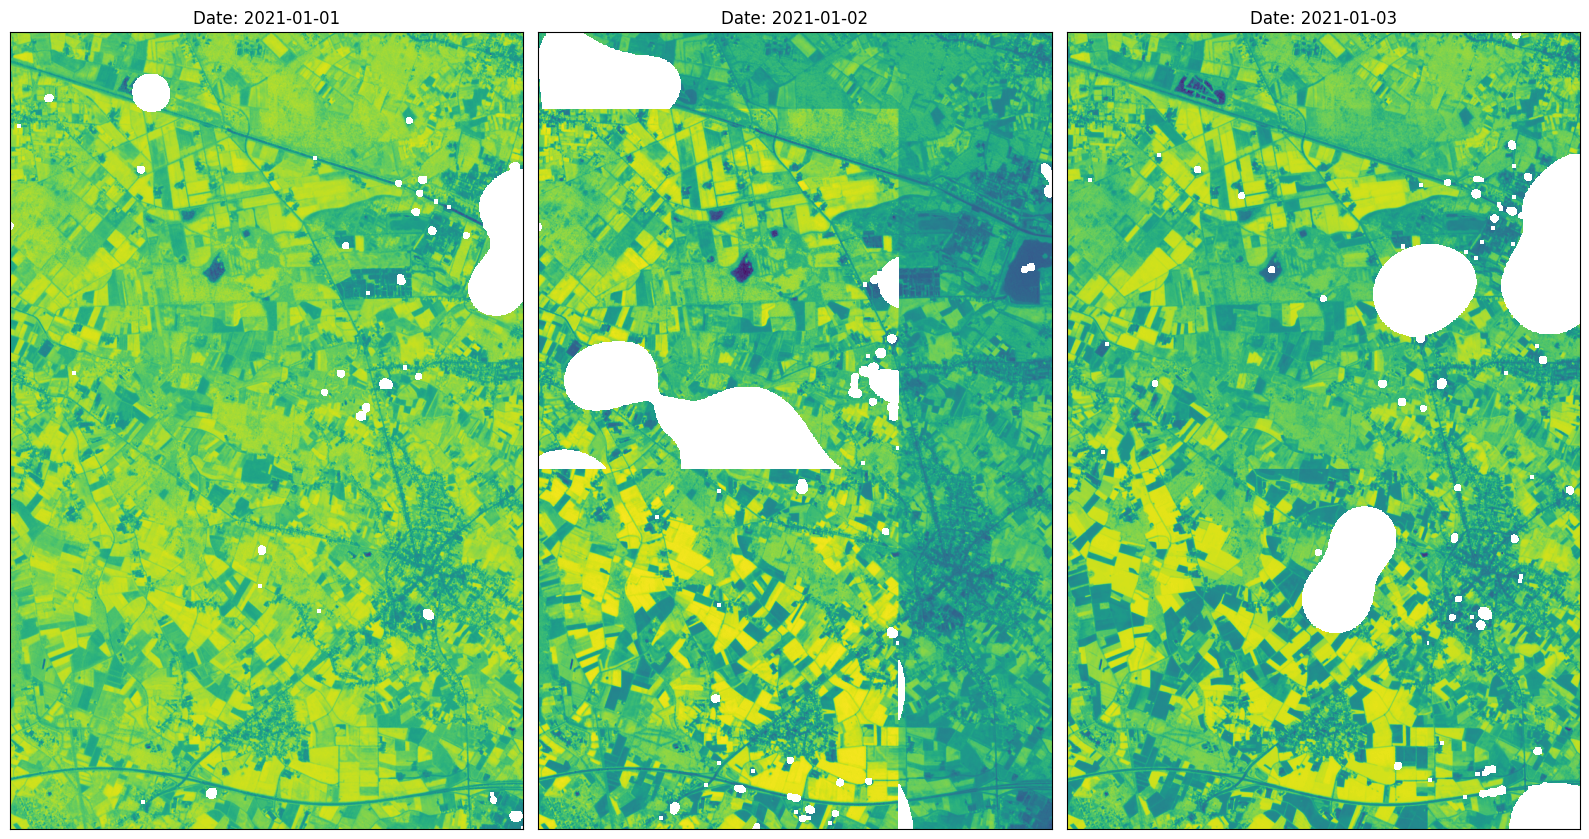

In [20]:
# Load your dataset
ndvi_data = xr.open_dataset(base_path / "ndvi_test_reduced1.nc")

# Access the "var" variable
var = ndvi_data["var"]

# Select the top 3 time steps
three_steps = var["t"][0:3]

# Create a 1x3 horizontal plot for the top 3 time steps
plt.figure(figsize=(16, 10))  # Adjust the figure size as needed
for i, t in enumerate(three_steps):
    plt.subplot(1, 3, i + 1)
    data_slice = var.sel(t=t)
    date = t.values.astype("M8[D]").astype("O")  # Convert to Python datetime object
    formatted_date = date.strftime("%Y-%m-%d")  # Format the date
    plt.imshow(data_slice, cmap="viridis", origin="lower")
    plt.title(f"Date: {formatted_date}")
    # Hide both horizontal and vertical ticks and labels
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()  # Ensures proper spacing between subplots
plt.show()

Note that the openEO Python clients generates an openEO process graph, which is then sent to one of the backends selected by the platform based on the operations that you are using. 
This process graph is then executed on selected platform. 
However, if you want to inspect intermediate results, you can, for example using `ndviband.download(...)` like above.
Executing this line will allow you to inspect the NDVI images. 



## Apply a tensorflow neural network

We now apply a neural network, that requires 128x128 pixel 'chunks' input. To avoid discontinuities between neighboring chunks, we work with an overlap of 32 pixels in all directions. The U-Net itself is trained on an input size of (x,y,1), that is, just one grayscale channel as an input, which is just one NDVI tile. However, we are using 12 NDVI images as an input (the 12 images selected in the previous step). That is because we are doing inference using 3 different models, 4 times per model. The final prediction is then the median of all predictions per pixel.

As you may know, a U-Net just like any other CNN applies a filter over an image. This can be done using `apply_neighborhood`, an openEO process defined here: https://openeo.org/documentation/1.0/processes.html#apply_neighborhood .


In [27]:
ndvi_job.job_id

'vito-j-240104b6fef249f2ad590ccc4dc7a81e'

In [20]:
ndviband = eoconn.load_result("vito-j-2401046c71a24363b111192dc3afa50e")

In [21]:
dependencies_url = "https://artifactory.vgt.vito.be:443/auxdata-public/openeo/onnx_dependencies.zip"
models_url = "https://artifactory.vgt.vito.be:443/artifactory/auxdata-public/openeo/parcelDelination/BelgiumCropMap_unet_3BandsGenerator_Models.zip"
job_options = {
    "udf-dependency-archives": [
        f"{dependencies_url}#onnx_deps",
        f"{models_url}#onnx_models",
    ],
}

In [22]:
#add local udf if tensorflow fails on Cop server
segmentationband_onnx = ndviband.apply_neighborhood(
    process=openeo.UDF.from_file("udf_segmentation.py"),
    size=[
        {"dimension": "x", "value": 64, "unit": "px"},
        {"dimension": "y", "value": 64, "unit": "px"},
    ],
    overlap=[
        {"dimension": "x", "value": 32, "unit": "px"},
        {"dimension": "y", "value": 32, "unit": "px"},
    ],
)

In [23]:
segmentation_onnx_job = segmentationband_onnx.create_job(
    title="segmentation_onnx_job", 
    out_format="NetCDF", 
    job_options=job_options
)
segmentation_onnx_job.start()

<BatchJob job_id='vito-j-240108ee3c444f3fa6a117e10d75554d'>

In [24]:
segmentation_onnx_job.status()

'running'

In [25]:
segmentation_onnx_job.download_result(base_path / "delineation_test_onnx2.nc")

WindowsPath('results/parcels/delineation_test_onnx2.nc')

The result of the U-Net is a map with more clearly defined boundaries, however the result is not optimal. We will therefore post-process our U-Net result by applying non-ML filters.


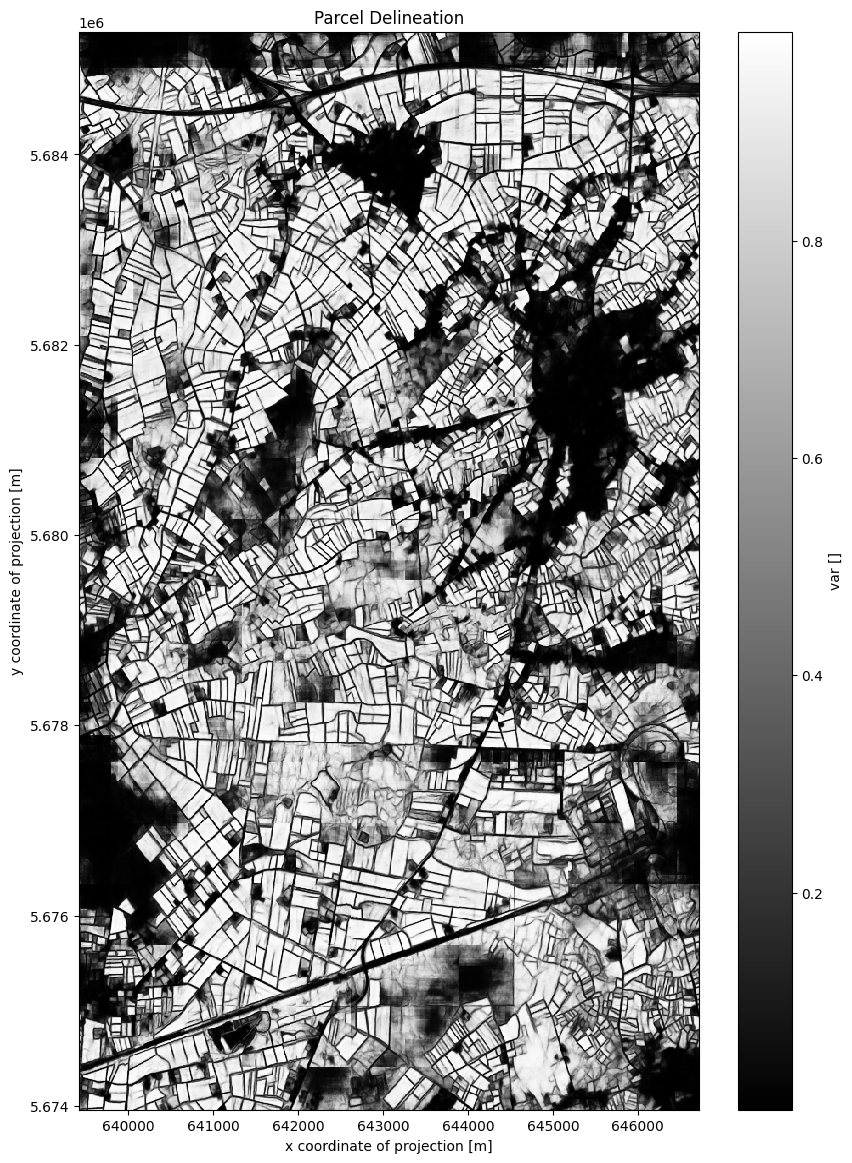

In [27]:
# Load your dataset
ds = xr.open_dataset(base_path / "delineation_test2.nc")
# ds = xr.open_dataset(base_path / "delineation.nc")

# Access the "var" variable
# var = ds["unkown_band_0"]
var = ds["var"]

# Plot the data
var.plot(figsize=(10, 14), cmap="gray")  # Use a colormap that suits your data
plt.title("Parcel Delineation")
plt.show()

## Segmentation postprocessing

We postprocess the output from the neural network using a sobel filter and Felzenszwalb's algorithm, which are then merged. This time, we work on larger chunks, to reduce the need for stitching the vector output.

In [20]:
segmentationband = segmentationband.apply_neighborhood(
    process=openeo.UDF.from_file("udf_sobel_felzenszwalb.py"),
    size=[
        {"dimension": "x", "value": 256, "unit": "px"},
        {"dimension": "y", "value": 256, "unit": "px"},
    ],
    overlap=[
        {"dimension": "x", "value": 0, "unit": "px"},
        {"dimension": "y", "value": 0, "unit": "px"},
    ],
)

In [21]:
job = segmentationband.execute_batch(outputfile=base_path / "delineation-filtered.nc")

0:00:00 Job 'vito-j-231102cf87874c28ab00d32de45310c2': send 'start'
0:00:17 Job 'vito-j-231102cf87874c28ab00d32de45310c2': queued (progress N/A)
0:00:23 Job 'vito-j-231102cf87874c28ab00d32de45310c2': queued (progress N/A)
0:00:29 Job 'vito-j-231102cf87874c28ab00d32de45310c2': queued (progress N/A)
0:00:38 Job 'vito-j-231102cf87874c28ab00d32de45310c2': queued (progress N/A)
0:00:48 Job 'vito-j-231102cf87874c28ab00d32de45310c2': queued (progress N/A)
0:01:01 Job 'vito-j-231102cf87874c28ab00d32de45310c2': queued (progress N/A)
0:01:16 Job 'vito-j-231102cf87874c28ab00d32de45310c2': queued (progress N/A)
0:01:36 Job 'vito-j-231102cf87874c28ab00d32de45310c2': queued (progress N/A)
0:02:00 Job 'vito-j-231102cf87874c28ab00d32de45310c2': queued (progress N/A)
0:02:30 Job 'vito-j-231102cf87874c28ab00d32de45310c2': running (progress N/A)
0:03:10 Job 'vito-j-231102cf87874c28ab00d32de45310c2': running (progress N/A)
0:03:57 Job 'vito-j-231102cf87874c28ab00d32de45310c2': running (progress N/A)
0:04:

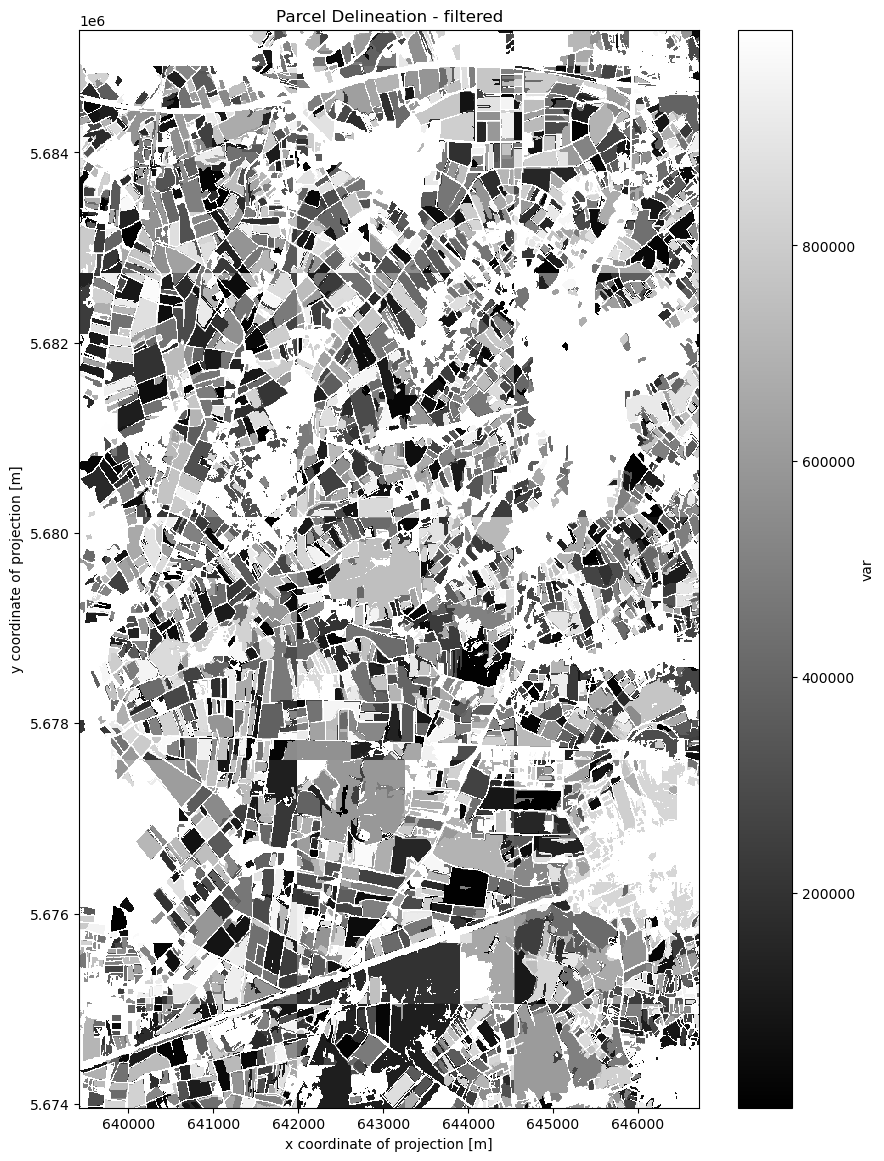

In [23]:
# Load your dataset
ds = xr.open_dataset(base_path / "delineation-filtered.nc")

# Access the "var" variable
var = ds["var"]

# Plot the data
var.plot(figsize=(10, 14), cmap="gray")  # Use a colormap that suits your data
plt.title("Parcel Delineation - filtered")
plt.show()

## Convert to vector

We are now ready to convert the raster image to vector. In openEO, we have an integrated process to do so, called `raster_to_vector`. You can read more about this method, or about other methods of interest, in our documentation: https://docs.openeo.cloud/processes/#raster_to_vector

In [24]:
vectorization = segmentationband.raster_to_vector()

job = vectorization.execute_batch(outputfile=base_path / "parcels.json")

0:00:00 Job 'vito-j-231102ada53f4a588654a0a31649dd39': send 'start'
0:00:20 Job 'vito-j-231102ada53f4a588654a0a31649dd39': queued (progress N/A)
0:00:26 Job 'vito-j-231102ada53f4a588654a0a31649dd39': queued (progress N/A)
0:00:34 Job 'vito-j-231102ada53f4a588654a0a31649dd39': queued (progress N/A)
0:00:42 Job 'vito-j-231102ada53f4a588654a0a31649dd39': queued (progress N/A)
0:00:53 Job 'vito-j-231102ada53f4a588654a0a31649dd39': queued (progress N/A)
0:01:07 Job 'vito-j-231102ada53f4a588654a0a31649dd39': queued (progress N/A)
0:01:24 Job 'vito-j-231102ada53f4a588654a0a31649dd39': queued (progress N/A)
0:01:43 Job 'vito-j-231102ada53f4a588654a0a31649dd39': running (progress N/A)
0:02:08 Job 'vito-j-231102ada53f4a588654a0a31649dd39': running (progress N/A)
0:02:39 Job 'vito-j-231102ada53f4a588654a0a31649dd39': running (progress N/A)
0:03:18 Job 'vito-j-231102ada53f4a588654a0a31649dd39': running (progress N/A)
0:04:05 Job 'vito-j-231102ada53f4a588654a0a31649dd39': running (progress N/A)
0:0

In [25]:
with open(base_path / "parcels.json") as f:
    polygons = json.load(f)

geom = [shape(p) for p in polygons]
parcels_gdf = gpd.GeoDataFrame(geometry=geom, crs="EPSG:32631")
parcels_gdf.to_file(str(base_path / "parcels.gpkg"), layer="parcels", driver="GPKG")

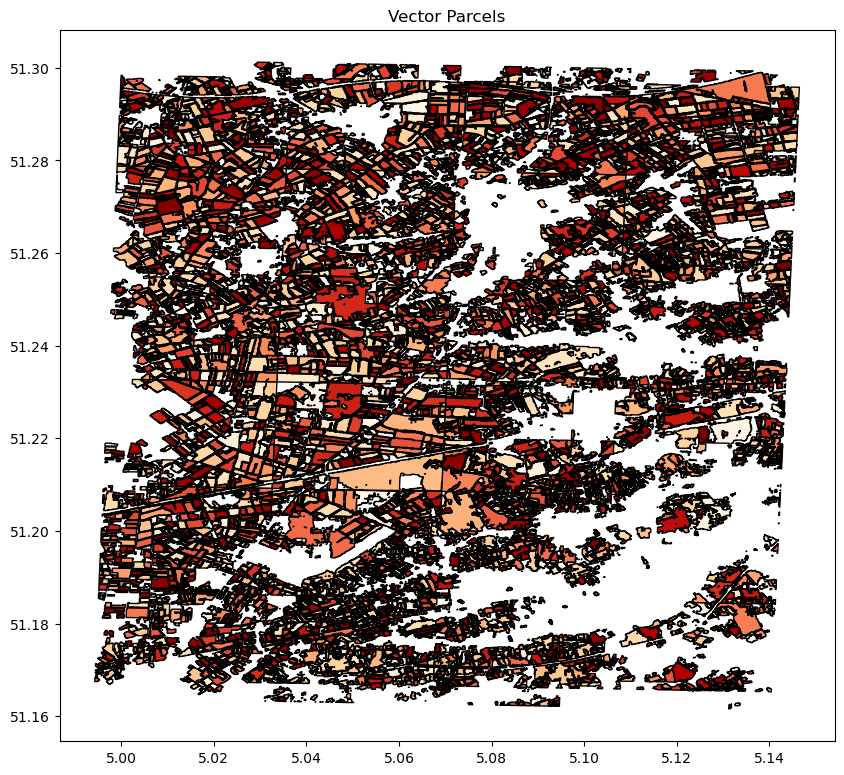

In [28]:
parcels_gdf.plot(cmap="OrRd", figsize=(10, 16), edgecolor="black")
plt.title("Vector Parcels")
plt.show()

## Sampling

If you are training your own network, openEO can be used to get training data. In general, a workflow that is often used by researchers using our platform is:
* data access, data preparation, feature engineering and sampling: openEO
* model training: outside of openEO (e.g. on GPU's)
* model inference: in openEO using UDF's

In this notebook we are only doing inference. But to show you how to sample data, this is a small section on how that would work. When you are training a CNN, you will likely already have a set of images (e.g. for this use case, a number of delineated fields at a certain date, with a certain spatial extent). Sampling would therefore consist of:
* Loading in a collection, like we did before
* Calculating whatever index, raw band, custom calculation, or collection of one of the aforementioned you need for your use case
* Applying openEO processes `filter_spatial` and `filter_temporal` on your image corresponding to the labeled images you already have
* Downloading the results using `execute_batch()` or `send_job()` (batch processing), or `download()` (synchronous processing, if your images are fairly small)

If you are using a recurrent net or another ML model where your input is flat (for example, a random forest, a booster, an SVM, ...) and you are sampling points rather than entire images, you can use `filter_spatial` to filter your feature cube to the points for which you actually have sampling data, and the option `sample_by_feature=True` to store them as a separate record. You can do the same thing with `aggregate_spatial`. You can find more information [here](https://open-eo.github.io/openeo-python-client/cookbook/sampling.html) as well as a notebook where it is applied, [here](https://github.com/openEOPlatform/SRR2_notebooks/blob/main/UC3%20-%20Crop%20type%20feature%20engineering%20using%20random%20forest.ipynb).

In [30]:
s2_bands = eoconn.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=[startdate, enddate],
    bands=["B04", "B08", "SCL"],
    max_cloud_cover=20,
)
s2_bands = s2_bands.process("mask_scl_dilation", data=s2_bands, scl_band_name="SCL")

ndviband = s2_bands.ndvi(red="B04", nir="B08")
ndviband = ndviband.apply_dimension(
    process=openeo.UDF.from_file("udf_reduce_images.py"),
    dimension="t",
)

training_data = ndviband.filter_spatial(json.load(open("resources/training_parcels.geojson")))
training_data.execute_batch(
    outputfile=base_path / "training_data.nc",
    sample_by_feature=True,
)